# Mapping the seasonal changes to the open water extent of the Okavango delta

* **Products used:** 
[ls7_sr](https://explorer.digitalearth.africa/products/ls7_sr), [ls8_sr](https://explorer.digitalearth.africa/products/ls8_sr)



## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr
import geopandas as gpd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:42163 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


## Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:
* `vector_file`: The path to the shapefile or geojson that will define the analysis area of the study
* `products`: The products to load from the datacube, e.g. `'s2_l2a``, or `'ls8_sr'`
* `time_range`: The date range to analyse (e.g. `('2017', '2019')`.
* `measurements`: The spectral bands to load from the satellite product. `MNDWI` requires the `'green'` and `'swir_1'` bands
* `resolution`: The pixel resolution of the satellite data. `(-30,30)` for Landsat or `(-10,10)` for Sentinel-2
* `dask_chunks`: Chunk sizes to use for dask, the default values below are optimized for the full Okavango delta

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The default area is the Ruko Conservancy. 


In [3]:
vector_file = 'data/okavango_delta_outline.geojson'

products = ['ls7_sr','ls8_sr']

wetness_index = 'MNDWI'

time_range = ('2013-12', '2021-05')

measurements = ['green','swir_1']

resolution = (-30,30)

dask_chunks = {'time':1,'x':1500,'y':1500}


## View the Area of Interest on an interative map
The next cell will  first open the vector file and then display the selected area on an interactive map.
Zoom in and out to get a better understanding of the area of interest.

In [4]:
#read shapefile
gdf = gpd.read_file(vector_file)

map_shapefile(gdf, attribute='GRID_CODE')

Label(value='')

Map(center=[-19.127784976273865, 22.81034225598682], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [5]:
dc = datacube.Datacube(app='water_extent')

## Load cloud-masked Satellite data

The first step is to load satellite data for the specified area of interest and time range. 

In [6]:
bbox=list(gdf.total_bounds)
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

#create the dc query
water_query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': 'EPSG:6933',
    'dask_chunks': dask_chunks,
    'group_by':'solar_day'
              }

Now load the satellite data

In [7]:
ds = load_ard(dc=dc,
              products=products,
              **water_query
                   )
print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls7_sr
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 934 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 934, x: 6955, y: 7774)
Coordinates:
  * time         (time) datetime64[ns] 2013-12-01T08:33:19.653638 ... 2021-05...
  * y            (y) float64 -2.279e+06 -2.279e+06 ... -2.512e+06 -2.513e+06
  * x            (x) float64 2.097e+06 2.097e+06 ... 2.305e+06 2.305e+06
    spatial_ref  int32 6933
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1500, 1500), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1500, 1500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Mask the satellite data with vector file

In [8]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)

## Calculate the wetness index

In [9]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index=[wetness_index], drop=True, collection='c2')

#convert to float 32 to conserve memory
ds=ds.astype(np.float32)

Dropping bands ['green', 'swir_1']


## Resample time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this we resample the data to seasonal time-steps using medians

These calculations will take **nearly an hour** to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.

In [10]:
%%time
sample_frequency="QS-DEC"  # quarterly starting in DEC, i.e. seasonal

#resample MNDWI using medians
print('calculating '+wetness_index+' seasonal medians...')
ds = ds.resample(time=sample_frequency, loffset='1M').median().compute()


calculating MNDWI seasonal medians
CPU times: user 14min 17s, sys: 29.2 s, total: 14min 46s
Wall time: 1h 1min 17s


### Facet plot the water extent for every season

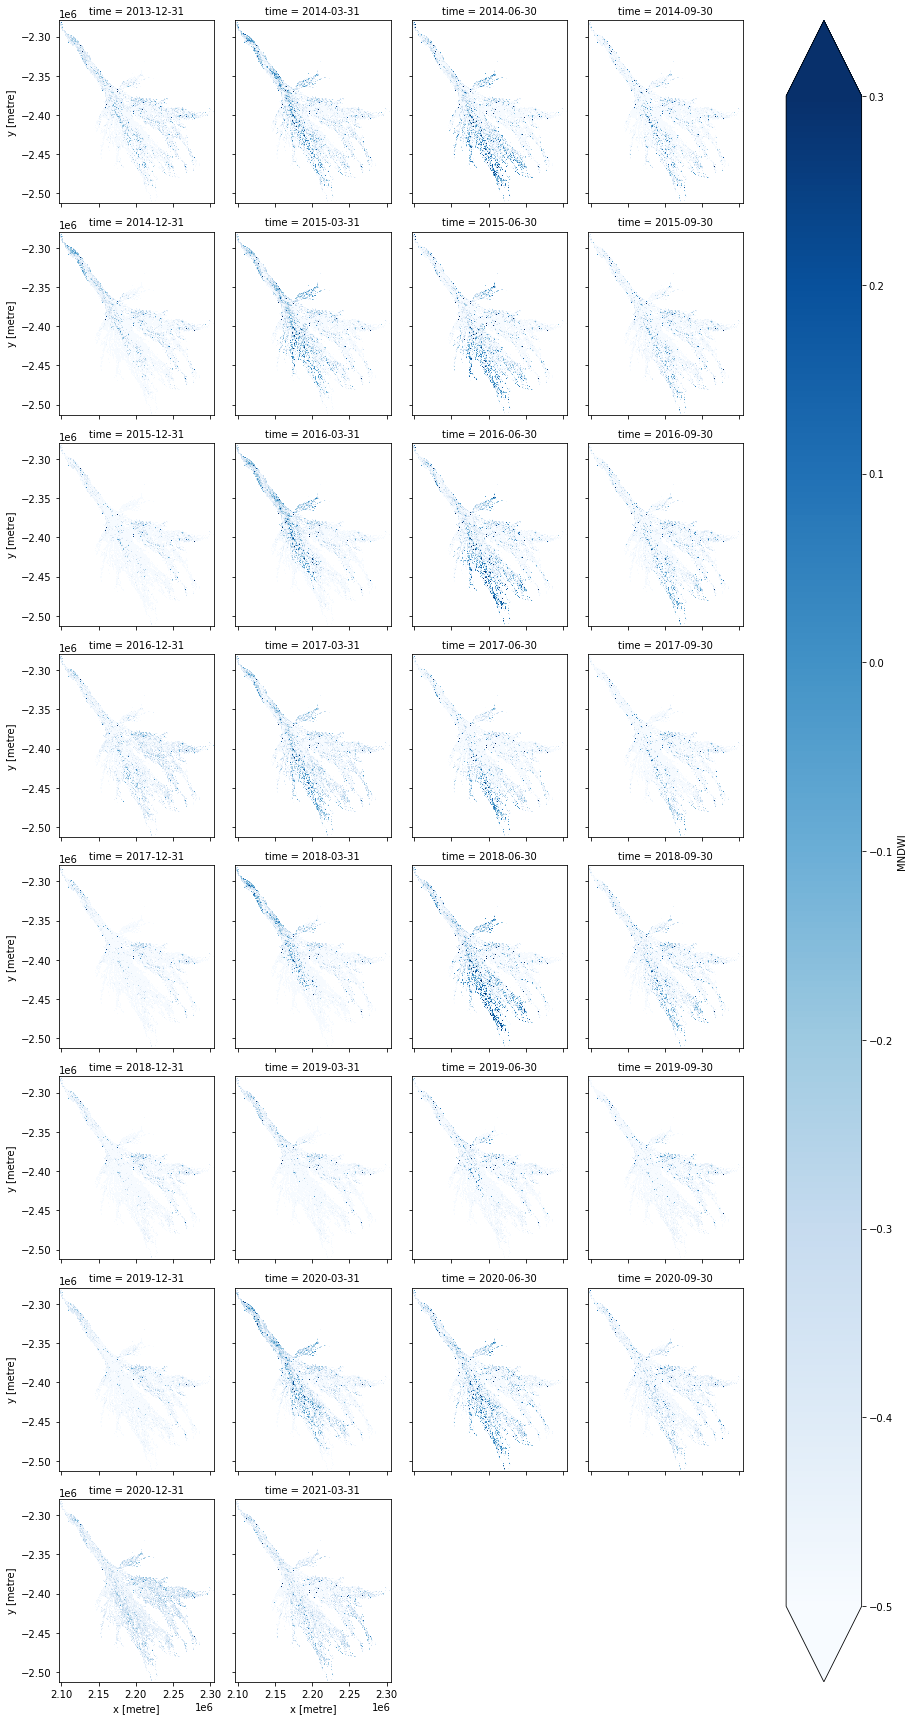

In [14]:
ds[wetness_index].plot.imshow(col='time', col_wrap=4, cmap='Blues', vmax=0.3, vmin=-0.5);

## Calculate the water extent per time-step

The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [12]:
pixel_length = water_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

## Calculating the extent of open water
Calculates the area of pixels classified as water (if MNDWI is > 0, the water)

In [13]:
water = ds[wetness_index].where(ds[wetness_index] > 0, np.nan)

area_ds = water.where(np.isnan(water), 1)

ds_valid_water_area = area_ds.sum(dim=['x', 'y']) * area_per_pixel

### Export time-series as csv

In [15]:
ds_valid_water_area.to_dataframe().drop('spatial_ref',axis=1).rename({'MNDWI':'Area of waterbodies (km2)'},axis=1).to_csv(f'results/water_extent_{time_range[0]}_to_{time_range[1]}.csv')

### Plot a time series of open water area

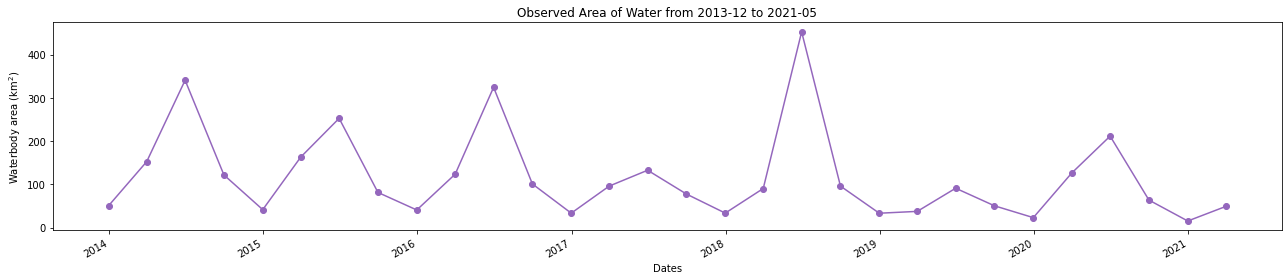

In [16]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Observed Area of Water from {time_range[0]} to {time_range[1]}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()
plt.savefig(f'results/water_extent_{time_range[0]}_to_{time_range[1]}.png')

## Compare water extent between two periods

* `baseline_time` : The baseline year for the analysis
* `analysis_time` : The year to compare to the baseline year


In [21]:
baseline_time = '2018-06-30'
analysis_time = '2019-06-30'

In [18]:
baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'),ds_valid_water_area.sel(time=analysis_time, method ='nearest')

time_xr = xr.DataArray([baseline_ds.time.values, analysis_ds.time.values], dims=["time"])
print(time_xr.values)

['2018-06-30T00:00:00.000000000' '2019-06-30T00:00:00.000000000']


## Plotting
Plot water extent of the MNDWI product for the two chosen periods.

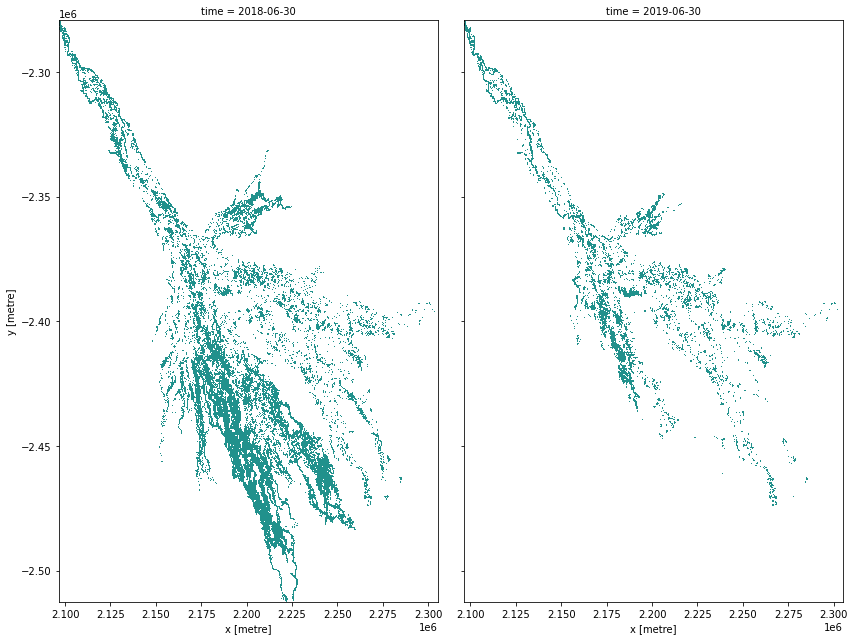

In [19]:
area_ds.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(12, 9), cmap='viridis', add_colorbar=False);

### Save the water extents as geotiffs 

Both the 'analysis time' and the 'baseline time' water extents will be saved as cloud-opimtised geotiffs in the `results/` folder

In [22]:
write_cog(area_ds.sel(time=baseline_time),
          fname='results/water_extent_'+baseline_time+'.tif',
          overwrite=True)

write_cog(area_ds.sel(time=analysis_time),
          fname='results/water_extent_'+analysis_time+'.tif',
          overwrite=True)

PosixPath('results/water_extent_2019-06-30.tif')

### Calculate the change between the two nominated periods

The cells below calculate the amount of water gain, loss and stable for the two periods

In [23]:
# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = area_ds.where(area_ds == 1, 0).sel(time=time_xr)

analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))
water_disappeared = change.where(change == -1)

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [24]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

## Plot the changes
The water variables are plotted to visualised the result

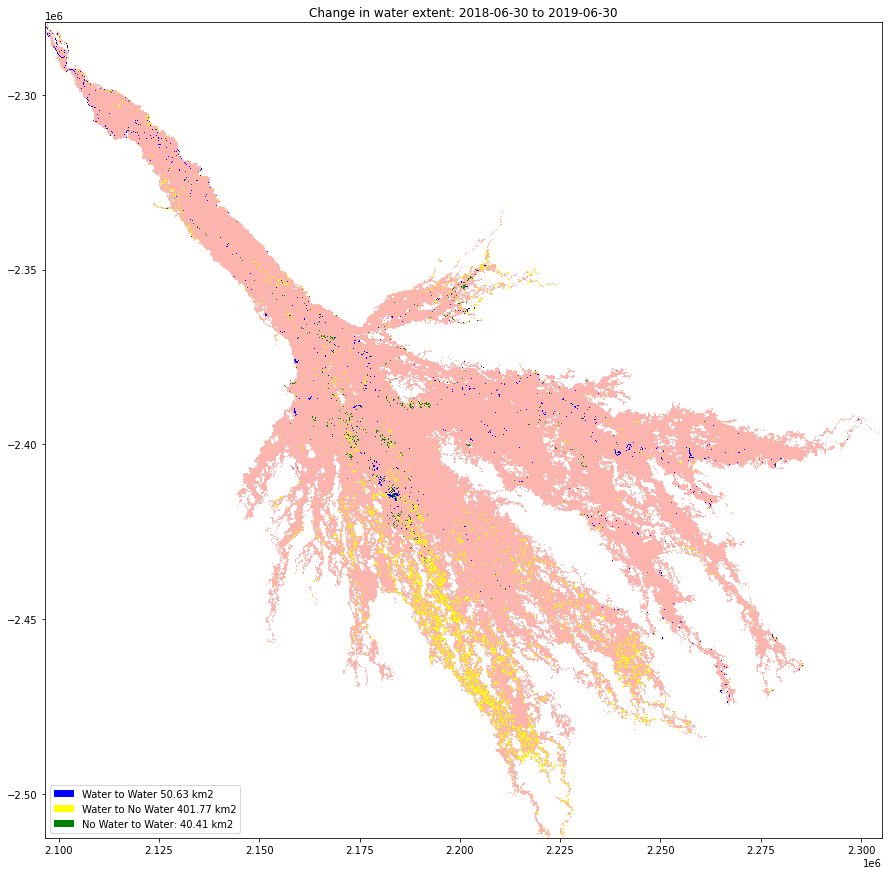

In [25]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ds_selected[1].where(mask).plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent: " + baseline_time + " to " + analysis_time);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [26]:
print(datacube.__version__)

1.8.4.dev193+g3997b90f


**Last Tested:**

In [27]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-07-13'